In [66]:
from __future__ import print_function
from __future__ import division

import os, sys
import collections
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import email
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from scipy import sparse, hstack
from sklearn.feature_extraction.text import *
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


# Helper libraries
import constants
import utils
import vocabulary

## Load in Email Bodies
Data source and exploration code: [Kaggle](https://www.kaggle.com/zichen/explore-enron)

In [2]:
# load csv dataset - download from Kaggle (linked above, ~.5gb)

# replace with local path
path = 'C:/Users/Colby/Documents/Berkeley/266_NLP/final_project/data'

# all emails for targeted search
all_emails = pd.read_csv(path + '/emails.csv')
#emails_df = pd.read_csv(path + '/emails.csv', rows = 50000)

print("Shape:", all_emails.shape)
all_emails.head()
#print(all_emails['message'][1])

Shape: (517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
# citation: Kaggle exploration code
# isolate email body
# run-time: ~ 3 minutes on full dataset

def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

# Parse the emails into a list email objects
messages = list(map(email.message_from_string, all_emails['message']))
#emails_df.drop('message', axis=1, inplace=True)

# Parse content from emails
all_emails['content_str'] = list(map(get_text_from_email, messages))

del messages

In [117]:
# mini version for preprocessing (to save run-time)
size = 5000
emails_df = all_emails.loc[range(size),]
print("Full shape:", all_emails.shape)
print("Mini shape:", emails_df.shape)

# for full preprocessing and training
emails_df = all_emails
emails_df.head()

Full shape: (517401, 3)
Mini shape: (5000, 3)


,file,message,content_str
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.


## Preprocess Raw Email Contents

In [118]:
# REPLACED

# tokenize and canonicalize each email to get vocab
# WARNING: THIS STEP TAKES ~30 MINUTES ON LOCAL MACHINE WHEN USING ALL 500K EMAILS
#tokenizer = TreebankWordTokenizer()
#all_tokens = []
#email_tokens = []
#emails_preprocessed = []

#for i, body in enumerate(emails_df["content_str"]):
    #get sentence level
#    sents = nltk.tokenize.sent_tokenize(body)
#    canon = []
#    proc_body = []
#    for sent in sents:
        #list of tokens in sentence
#        sent_tokens = tokenizer.tokenize(sent.lower())
#        canon += utils.canonicalize_words(sent_tokens)
#        new_sent = ["<s>"]
#        for w in canon:
#            if w != "," and "--" not in w and "@" not in w and "http" not in w:
#                new_sent += w
        # remove digits
#        proc_body += new_sent
#    emails_preprocessed.append(proc_body)

#emails_df["content_tokens"] = email_tokens
#print("Total Number of Tokens:", len(all_tokens))
#emails_df["content_proc"] = emails_preprocessed
#emails_df.head()

In [119]:
# build vocab
# V = size
#V = 10000
#vocab = vocabulary.Vocabulary(all_tokens, size=V)
#vocab = vocabulary.Vocabulary(all_tokens)
#print("Vocabulary size: {:,}".format(vocab.size))
#vocab_ids = vocab.words_to_ids(all_tokens)
#print("Unigrams: ", len(vocab.unigram_counts))

#emails_df.head()

In [120]:
# PREPROCESSING STEP
# run-time = 30 mins on local machine with FULL dataset

tokenizer = TreebankWordTokenizer()

# preprocess email bodies with unknowns and sentence buffers
emails_preprocessed = []

for i, body in enumerate(emails_df["content_str"]):
    #get sentence level
    sents = nltk.tokenize.sent_tokenize(body.lower())
    list_sents = []
    canon = []
    for sent in sents:
        #list of tokens in sentence
        sent_tokens = tokenizer.tokenize(sent)
        new_sent = []
        for w in sent_tokens:
            re.sub("-","",w)
            if (w!="," and w!="." and "--" not in w and "@" not in w and "forwarded" not in w and "http" not in w and "www." not in w):
                new_sent += [w]
        #canon += utils.canonicalize_words(sent_tokens)
        list_sents += utils.canonicalize_words(new_sent)+["<s>"]
        #if canon != "," and canon != "." and "--" not in canon and "@" not in canon and "http" not in canon:
            #list_sents += canon+["<s>"]
    #preprocessed = list(utils.preprocess_sentences(list_sents, vocab, use_eos=True, emit_ids=False))
    #just keep word IDs
    #preprocessed = list_sents
    emails_preprocessed.append(list_sents)

emails_df["content_proc"] = emails_preprocessed
#emails_preprocessed[2]
#print(emails_df.shape)
emails_df.head()

TypeError: 'tuple' object is not callable

#### Limit Length of Emails to 2,000 Preprocessed Words

In [121]:
# final preprocessed strings for feature generation
#emails_df["content_proc"] = emails_df["content_IDS"].apply(lambda x: ' '.join(vocab.ids_to_words(x)))
# email length feature
print(emails_df.shape)
emails_df["content_length"] = emails_df["content_proc"].apply(len)
emails_df.head()

(517401, 4)


,file,message,content_str,content_proc,content_length
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,"[here, is, our, forecast, <s>]",5
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta...",150
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"[test, successful, <s>, way, to, go, !, !, <s>...",11
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","[randy, can, you, send, me, a, schedule, of, t...",39
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",8


content_length
323047     41737
74321      42784
58523      42784
59058      44690
73895      44690
323051     44711
323616     45325
58238      45872
74539      45872
260177     47647
368235     49317
323166     50611
323180     51851
323620     53811
56264      54368
75868      54368
323068     60536
323624     69620
365604    210253
114312    247974
Name: content_length, dtype: int64


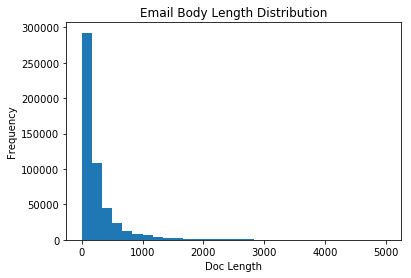

In [122]:
top_20 = np.argsort(emails_df["content_length"]).tail(20)
print(emails_df["content_length"][top_20])
plt.hist(np.array(emails_df["content_length"]), bins=30, range=(0,5000))
plt.title("Email Body Length Distribution")
plt.xlabel("Doc Length")
plt.ylabel("Frequency")
plt.show()

In [123]:
max_len = 2500
emails_df["email_list"] = emails_df["content_proc"].apply(lambda x: x[0:min(len(x), max_len)])
emails_df["email_str"] = emails_df["email_list"].apply(lambda x: ' '.join(x))
emails_df.head()

,file,message,content_str,content_proc,content_length,email_list,email_str
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,"[here, is, our, forecast, <s>]",5,"[here, is, our, forecast, <s>]",here is our forecast <s>
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta...",150,"[traveling, to, have, a, business, meeting, ta...",traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"[test, successful, <s>, way, to, go, !, !, <s>...",11,"[test, successful, <s>, way, to, go, !, !, <s>...",test successful <s> way to go ! ! <s> ! <s>
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","[randy, can, you, send, me, a, schedule, of, t...",39,"[randy, can, you, send, me, a, schedule, of, t...",randy can you send me a schedule of the salary...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",8,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",let 's shoot for tuesday at DGDG:DGDG <s>


## Query Raw Contents for Suspicious Phrases
### Targeted Heuristics with Phrase Searches
Use this block to search raw messages and store the row indexes in *target_ids*

In [116]:
# test phrase - enter between quotes
phrase = "fraud"

query = emails_df[emails_df['email_str'].str.contains(phrase, case=False)]
print(query.shape)
print("Matching indexes:", query.index.tolist())

(4, 7)
Matching indexes: [1332, 3054, 3947, 3949]


In [115]:
# enter matching index from list above
enter_id = 3443
print(query.loc[enter_id,'content_str'])

# store ids here in the form {123: 1, 456: 1, ...}
target_dict = {16212: 1, 450200: 1, 114757: 1, 373: 1, 346: 1, 405: 1, 27091: 1, 13966: 1, 8861: 1, 92183: 1, 17932: 1, 12955: 1, 8101: 1, 19004: 1,
              32643: 1, 511: 1, 908: 1}

remind jim how the h/j/k spread acted this year.  granted it won't behave 
that way again until close to expiry, but i like the j/k outright much moreso 
than the condor.




Caroline Abramo@ENRON
04/30/2001 12:24 PM
To: John Arnold/HOU/ECT@ECT
cc:  
Subject: pulaski


---------------------- Forwarded by Caroline Abramo/Corp/Enron on 04/30/2001 
01:23 PM ---------------------------


Jim Pulaski <Jim.Pulaski@tudor.com> on 04/30/2001 12:17:09 PM
To: "Caroline. Abramo (E-mail)" <Caroline.Abramo@enron.com>
cc:  

Subject: 


btw,  that wasnt me buying the f-g/j-k on friday at 4






### Review a Random Sample for Labeling

200 examples from first 50,000 emails in the dataset

In [9]:
# keep seed = 24 for sample of first 50000 emails
random.seed(24)
rand_num = 100
rand_ids_1 = random.sample(range(2000), rand_num)
rand_ids_2 = random.sample(range(2000,50000), rand_num)
rand_ids = rand_ids_1 + rand_ids_2
rand_set = emails_df.loc[rand_ids,]
#print(rand_ids)
print("Sample set shape:", rand_set.shape)
#for id_ in rand_ids:
#    print(id_)
#    print(rand_set.loc[id_, 'content_str'])

# assign labels based on id
label_dict = {373: 1, 346: 1, 405: 1, 27091: 1, 13966: 1}
rand_set["suspicious_ind"] = np.zeros(len(rand_ids))
for k in label_dict.keys():
    rand_set.loc[k, "suspicious_ind"] = label_dict.get(k)

Sample set shape: (200, 3)


In [10]:
rand_set.head()

,file,message,content_str,suspicious_ind
1458,allen-p/deleted_items/381.,Message-ID: <26393700.1075862162007.JavaMail.e...,[IMAGE]\n [IMAGE][IMAGE] [IMAGE] Yahoo! ...,0.0
784,allen-p/all_documents/266.,Message-ID: <16945.1075855671306.JavaMail.evan...,"Kay & Neal,\n\nThanks for remembering my birth...",0.0
1719,allen-p/discussion_threads/212.,Message-ID: <19120705.1075855677934.JavaMail.e...,Attached are two files that illustrate the fo...,0.0
1193,allen-p/all_documents/73.,Message-ID: <22565759.1075855667097.JavaMail.e...,Put me down as a reviewer,0.0
373,allen-p/_sent_mail/439.,Message-ID: <14134673.1075855725697.JavaMail.e...,"Jacques,\n\nStill trying to close the loop on ...",1.0


### Rules-Based Labeling from Other Enron Email Studies

## Generate BOW features and longer N-grams

In [106]:
# generate BOW features based on vocab.size V (above) and transform to TF-IDF
# uses canonicalized words
#bow_feats = utils.id_lists_to_sparse_bow(emails_df["content_IDS"], vocab.size)
#print("BOW shape: ", bow_feats.shape)
#transformer = TfidfTransformer()
#bow_tfidf = transformer.fit_transform(bow_feats)
#print("BOW TF-IDF:", bow_tfidf.shape)

# TOO MANY ODD TOKENS CAPTURED BY VOCAB OBJECT

BOW shape:  (50000, 5000)
BOW TF-IDF: (50000, 5000)


In [25]:
# consider longer n-grams
transformer = TfidfTransformer()
vectorize = CountVectorizer(ngram_range=(1, 2), max_df=.1, min_df=20)
n_grams = vectorize.fit_transform(emails_df["content_proc"])
print("N-grams shape: ", n_grams.shape)

n_grams_idf = transformer.fit_transform(n_grams)
print("N-grams TF-IDF:", n_grams_idf.shape)

N-grams shape:  (50000, 75864)
N-grams TF-IDF: (50000, 75864)


In [26]:
# join features
length_sparse = sparse.csr_matrix(emails_df["email_length"]).transpose()
# with length feature
#feature_vects = sparse.hstack([length_sparse, bow_tfidf, n_grams_idf])
#feature_vects = sparse.hstack([bow_tfidf, n_grams_idf])
feature_vects = n_grams_idf
feature_vects.shape

(50000, 75864)

### Fit & Evaluate Simple K-Means Clustering

In [27]:
# fit k-means (n=4, tol=.01, max_iter=100 takes ~20 mins to train)
kmeans = KMeans(n_clusters=5, tol=.01, max_iter=100)
kmeans.fit(feature_vects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.01, verbose=0)

In [28]:
# evaluate predictions on positively labeled examples
base_preds = kmeans.predict(feature_vects)
print("First 30 clusters:", base_preds[:30])
print("Positive labels:  ", base_preds[list(label_dict.keys())])

First 30 clusters: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Positive labels:   [2 2 2 2 2]


In [29]:
# evaluate closest examples in cluster 2 based on cosine similarity
suspicious_ids = np.zeros(len(base_preds))
for k in label_dict.keys():
    suspicious_ids[k] = label_dict.get(k)

# enter index of typical cluster
key_cluster = 2

cluster_ids = (base_preds==key_cluster).astype(int)

features_np = sparse.csr_matrix.todense(feature_vects)

labeled_feats = features_np[np.multiply(suspicious_ids, cluster_ids).astype(bool)]
print(labeled_feats.shape)

(5, 75864)


In [43]:
# cosine_similarity
print(label_dict.keys())
cos_sims = cosine_similarity(labeled_feats, feature_vects)
print(cos_sims.shape)
closest = np.argsort(cos_sims, axis = 1)
print(closest[:,-10:])
print(cos_sims[1,985])

dict_keys([346, 27091, 373, 13966, 405])
(5, 50000)
[[21177 31738 39744 13961 11650 15532  7014   966   346  2759]
 [  985  2779  1893  2769   356   976  1879   373  2787   995]
 [  357   358  1892  2771   978   977  2820  1855   405  1027]
 [17248 10977 14371 11429 16116 13982 11606 13966  9998 17433]
 [20382 19225 29563 21933 27092 30259 24055 31124 27091 20569]]
0.164362146998


In [37]:
# nearest emails flagged:
emails_df.loc[985, "content_proc"]

"<s> jacques , the agreement looks fine . </s> <s> my only comment is that george and larry might object to the language that `` the bank that was requested to finance the construction of the project declined to make the loan based on the high costs of the construction of the project '' . </s> <s> <unk> , that bank lowered the loan amount based on lower estimates of <unk> which <unk> the amount of equity that would be required . </s> <s> did i loan them $ DGDGDGDGDGDGDG ? </s> <s> i thought it was less . </s> <s> regarding exhibit a , the assets include : the land , <unk> plans , engineering completed , appraisal , and <unk> study . </s> <s> most of these items are in a state of partial completion by the consultants . </s> <s> i have been speaking directly to the architect , engineer , and <unk> engineer . </s> <s> i am unclear on what is the best way to proceed with these consultants . </s> <s> the obligations should include the fees owed to the consultants above . </s> <s> do we need